## 1. Setup

In [1]:
import dsutils
import numpy as np
from glob import glob
from PIL import Image
from transformers import AutoModel, AutoImageProcessor

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DEVICE = 'cuda:6'

ROOT_DIR = '/hdd1/ysyoon/datasets/'
DATASET_NAMES = [
    'aihub-landcover-satellite-all',
    'aihub-satellite-object-cloud',
    'eorssd',
    'isaid',
    'open-earth-map',
    'orsi-sod'
]

## 2. Build

In [3]:
model_name = '../ckpts/035000/'

In [ ]:
model_name = '../ckpts/035000/'

In [4]:
image_processor = AutoImageProcessor.from_pretrained(model_name, trust_remote_code=True)

In [5]:
model = AutoModel.from_pretrained(model_name, trust_remote_code=True)
_ = model.eval().requires_grad_(False).to(DEVICE)

In [6]:
model_org = AutoModel.from_pretrained('/hdd1/ysyoon/models/seggpt_vit-large/', trust_remote_code=True)
_ = model_org.eval().requires_grad_(False).to(DEVICE)

## 3. Inference

In [19]:
dataset_name = DATASET_NAMES[3]
dataset_name

'isaid'

In [20]:
image_paths = sorted(glob(f'{ROOT_DIR}/{dataset_name}/post/valid/images/*scale-1-0*.png'))

In [21]:
prompt_idx = 4
input_idx = 8

prompt_image_path = image_paths[prompt_idx]
prompt_label_path = prompt_image_path.replace('/images/', '/labels/')
input_image_path = image_paths[input_idx]
input_label_path = input_image_path.replace('/images/', '/labels/')

prompt_image = Image.open(prompt_image_path)
prompt_label = Image.open(prompt_label_path)
input_image = Image.open(input_image_path)
input_label = Image.open(input_label_path)

In [22]:
prompt_label = np.array(prompt_label)
input_label = np.array(input_label)

unique_classes = np.unique(prompt_label)
unique_classes = unique_classes[unique_classes>0]

c = np.random.choice(unique_classes)
print('class: ', c)
assert c > 0

prompt_label = np.where(prompt_label==c, 1, 0)
input_label = np.where(input_label==c, 1, 0)

palette = [[0,0,0], [255,255,255]]
prompt_label = dsutils.segmentation.visualize_label(prompt_label, palette)
input_label = dsutils.segmentation.visualize_label(input_label, palette)

class:  9


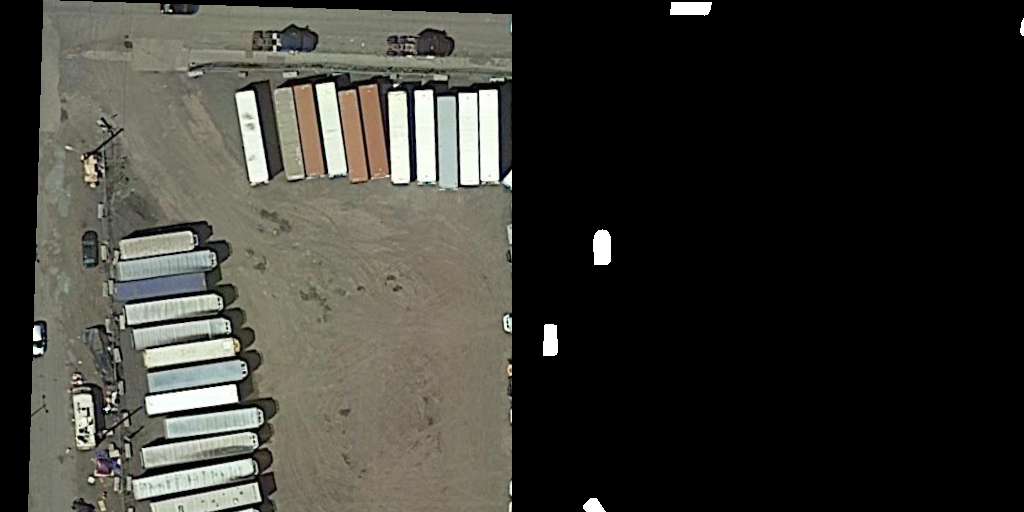

In [23]:
dsutils.image.concat_images_horizontal([prompt_image, prompt_label])

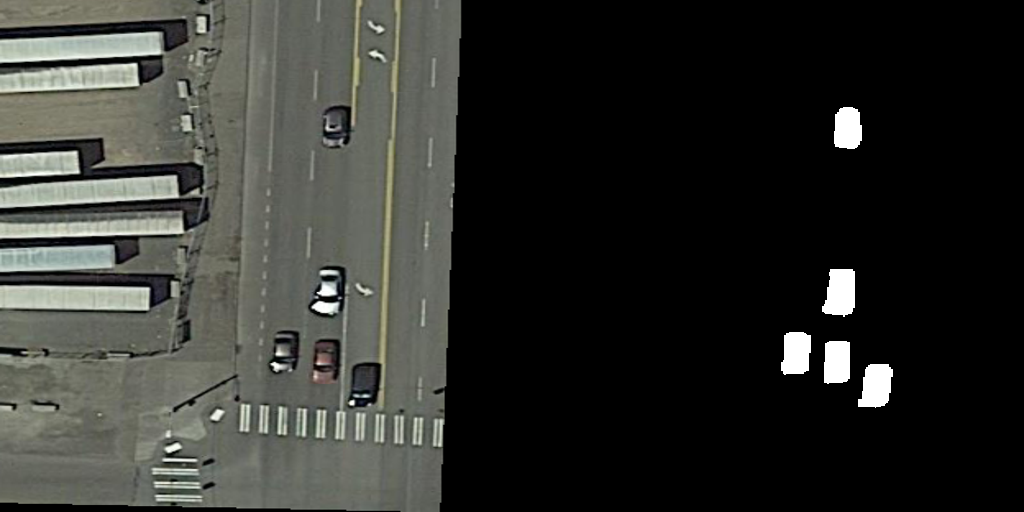

In [24]:
dsutils.image.concat_images_horizontal([input_image, input_label])

In [31]:
# inputs = image_processor(prompt_image, prompt_label, prompt_image, prompt_label, return_tensors='pt')
inputs = image_processor(prompt_image, prompt_label, input_image, input_label, return_tensors='pt')
inputs['masks'] = image_processor.generate_mask(1)
inputs = inputs.to(DEVICE)

In [32]:
outputs = model(**inputs)
pred = outputs.preds[0][:, 448:]
pred = dsutils.image.tensor_to_image(pred).resize((512, 512))

outputs_org = model_org(**inputs)
pred_org = outputs_org.preds[0][:, 448:]
pred_org = dsutils.image.tensor_to_image(pred_org).resize((512, 512))

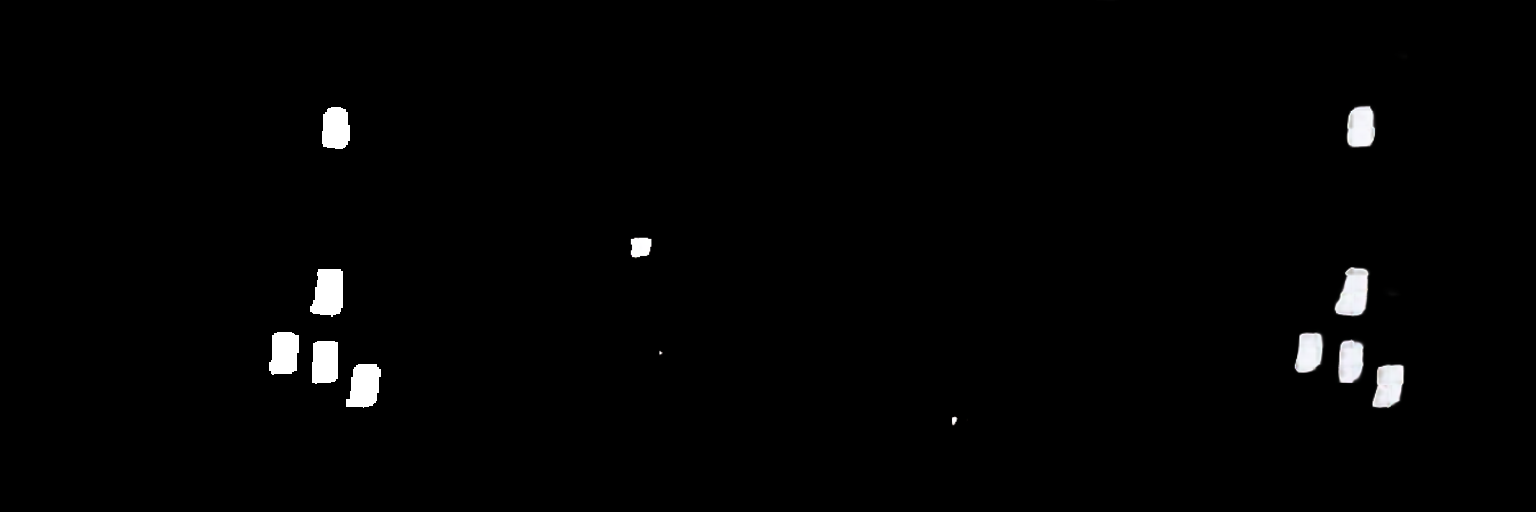

In [33]:
# dsutils.image.concat_images_horizontal([prompt_label, pred, pred_org])
dsutils.image.concat_images_horizontal([input_label, pred, pred_org])